# Oculusal Analysis

This Jupyter notebook contents the algorithm to analice an a image with bite register, wedge and measure reference.

### Import packages

In [1]:
from PIL import Image, ImageOps, ImageChops, ImageFilter
from numpy import asarray
import os
from matplotlib import pyplot
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import cv2
import functools 
from numba import vectorize, float64, int64
# import mascara as mask

### Loading images

In [2]:
image = Image.open('Samsung.jpg')
image_bw = image.convert(mode = "L") # Transform to black and white
print(image_bw.size) # [0]: width in pixels [1]: height in pixels

(2448, 3264)


### Step 1: cut images
(1) widge: It is used for convert the units in terms of deep pixel to distans in millimeters of the center.
(2) bite: Image to analyze
(3) measure guide: It is used for convert pixel to millimeters.


In [3]:
bite_params = (500, 600, 2300, 2200)
guide_params = (30, 2400, 200, 2650)
wedge_params = (1050, 2650, 1400, 2950)

In [4]:
bite = np.array(image_bw.crop(bite_params))
guide = np.array(image_bw.crop(guide_params))
wedge = np.array(image_bw.crop(wedge_params))

In [5]:
# photo.paste("black",(100,100,200,200))
bite2 = image_bw.crop(bite_params)
bite2.save('bite.jpg')
bite2.close()

In [6]:
print(bite.shape)
print(guide.shape)
print(wedge.shape)

(1600, 1800)
(250, 170)
(300, 350)


### Step 2: convert millimeters to pixels
Calculate the equivalence between pixels and millimeters


(250, 170)

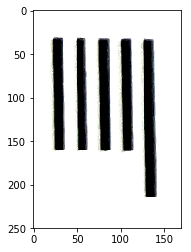

In [7]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

guide_cont = change_contrast(image, 100)
guide_cont = np.array(guide_cont.crop(guide_params))

plt.imshow(guide_cont)
guide_cont = cv2.cvtColor(guide_cont,cv2.COLOR_BGR2GRAY)
guide_cont.shape

In [8]:
x = "10"
float(x)

10.0

In [9]:
mid = round(guide_cont.shape[0]/2)
zeros = [i for i, e in enumerate(guide_cont[mid]) if e == 0]

In [10]:
sum_t = 0
count = 0
pix = []
for i in range(len(zeros)-1):
    if((zeros[i+1]-zeros[i]) == 1):
        sum_t = sum_t + zeros[i]
        count = count + 1
    else:
        pix.append(round(sum_t/count))
        sum_t = 0
        count = 0

In [11]:
mm = round(np.mean(np.diff(pix)))
mm

26.0

### Step 3: Convert depth pixel to millimeters
Using the wedge to convert each pixel depth to equivalent millimeters from the center of the wedge

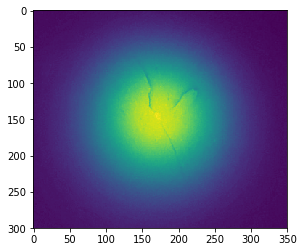

In [12]:
wedge_w = []

for i in range(wedge.shape[0]):
    x = list(wedge[i])
    wedge_w.append(max(x))
pix_med_y = wedge_w.index(max(wedge_w))
plt.imshow(wedge)

In [13]:
pix_med_x = np.argmax(wedge[pix_med_y])

In [14]:
print(pix_med_x)
print(pix_med_y)

170
145


After calibrate the center of widge, calculate the value of each depth in terms of millimeters

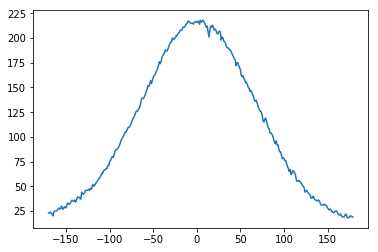

In [15]:
dist = []
prof = []
dist_p = []
for i in range(wedge.shape[1]):
        dist.append((i - pix_med_x)/mm)
        dist_p.append((i - pix_med_x))
        prof.append(wedge[pix_med_x][i])

plt.plot(dist_p, prof)
data_wedge_dist = pd.DataFrame({"d_pix":prof, "x_pix":dist_p, "x_mm":dist})

,d_pix,x_pix,x_mm
240,132,70,2.692308
241,129,71,2.730769
242,127,72,2.769231
243,126,73,2.807692
244,125,74,2.846154
245,122,75,2.884615
246,116,76,2.923077
247,115,77,2.961538
248,118,78,3.000000
249,119,79,3.038462


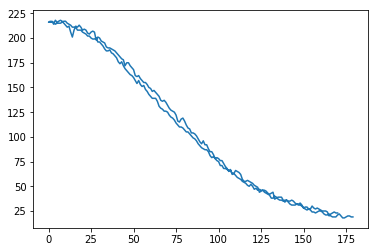

In [16]:
dist = []
prof = []
dist_p = []
for i in range(wedge.shape[1]):
        dist.append(np.abs(i - pix_med_x)/mm)
        dist_p.append(np.abs(i - pix_med_x))
        prof.append(wedge[pix_med_x][i])

plt.plot(dist_p, prof)
data_wedge_dist = pd.DataFrame({"d_pix":prof, "x_pix":dist_p, "x_mm":dist})
data_wedge_dist[240:280]

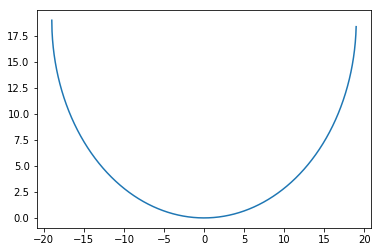

In [17]:
import pandas as pd
x = np.arange(-19, 19, 0.01)

def tomm(w):
    return -np.sqrt(361-w*w) + 19
#     return -1/2*np.sqrt(22201-4*w*w)

y = list(map(tomm, x))
y_pix = list(map(lambda w: round(w*mm), y))
x_pix = list(map(lambda w: round(w*mm), x))

data_wedge_depth = pd.DataFrame({"x_mill":x, "y_mill":y, "y_pix":y_pix, "x_pix":x_pix})
plt.plot(data_wedge_depth["x_mill"], data_wedge_depth["y_mill"])
# data_wedge_depth

In [18]:
wedge_dd = data_wedge_depth.merge(data_wedge_dist)
wedge_xd = wedge_dd.groupby("x_pix").median().reset_index()
wedge_dd = wedge_dd.groupby("d_pix").median().reset_index()

In [19]:
k_pix = min(np.array(wedge_dd[wedge_dd.y_mill <= 0.05]["d_pix"]))
w_pix = min(np.array(wedge_dd[wedge_dd.y_mill <= 0.35]["d_pix"]))
print(k_pix)
print(w_pix)

187
87


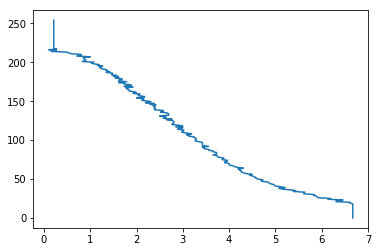

In [20]:
def depth_found(dist, a):
    y =  [i for i, e in enumerate(prof) if e == a]
    if(len(y)== 0):
        return "not found"
    else:
        return np.median([dist[i] for i in y])

distances = []
depths = []

for i in range(255):
    distances.append(depth_found(dist, i))
    depths.append(i)
    
for i in range(len(distances)):
    if(i == 0 and distances[i]=="not found"):
        aux = [x for x in distances if x!= "not found"]
        distances[i] = max(aux)
    if(distances[i] == "not found"):
        distances[i] = distances[i - 1]

# To get every depths, put it in the index of "distances"
plt.plot(distances,depths)

### Step 5: calculate the maximun depth
In this step, the maximun depth for the contacts is calculated

In [ ]:
# print(max([x for x in distances if x <= 0.05]))
# k = min([i for i, e in enumerate(distances) if e <= 0.05])
# w = min([i for i, e in enumerate(distances) if e <= 0.35])
# k

### Step 4: Transform each pixel distance
Here, each depth pixel on the bite is transform to its equivalent millimeters distance to the center of the wedge.

In [21]:
@vectorize([int64(float64)])
def redondear(x):
    return x

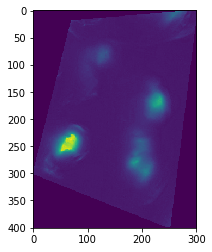

In [22]:
# bite = np.array(image.crop(bite_params))
cut_params = [(150,1100),(220,820),(450.40,800),(400,1200.18)]
cut_params = redondear(cut_params)
pts = np.array(cut_params)
## (1) Crop the bounding rect
rect = cv2.boundingRect(pts)
x,y,w,h = rect
croped = bite[y:y+h, x:x+w].copy()

## (2) make mask
pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8)*255
# cv2.bitwise_not(bg,bg, mask=mask)
plt.imshow(dst)
# max(dst[250])
# plt.imshow(255-dst)

In [ ]:
croped

In [ ]:
dst

In [23]:
class Switch(dict):
    def __getitem__(self, item):
        for key in self.keys():                   # iterate over the intervals
            if item in key:                       # if the argument is part of that interval
                return super().__getitem__(key)   # return its associated value
        raise KeyError(item)                      # if not in any interval, raise KeyError

switch = Switch({
    range(k_pix, 255): 2,
    range(w_pix, k_pix): 1,
    range(0, w_pix): 0
})
print(k_pix)
print(w_pix)

187
87


In [ ]:
# classification = dst.copy()
# for i in range(dst.shape[0]):
#     classification[i] = [switch[x] for x in dst[i]]

In [24]:
@vectorize([float64(float64)])
def f(x):
    return switch[x]

In [25]:
classification = f(dst)

In [ ]:
# (clasification1 == clasification).all()

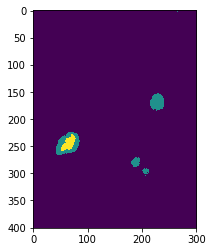

In [26]:
plt.imshow(classification)

In [27]:
low = 0
contact = 0
close = 0
for i in range(classification.shape[0]):
    for j in range(classification.shape[1]):
            if(classification[i][j] == 0):
                low = low + 1
            if(classification[i][j] == 1):
                close = close +1
            if(classification[i][j] == 2):
                contact = contact +1

### Calculate the area and number of contacts and close areas

In [28]:
area_contact = (1/mm**2)*contact
area_close = (1/mm**2)*close
print(area_contact)
print(area_close)

0.6789940828402367
2.75


In [29]:
classification.shape[0]

401

In [30]:
contactos = []
for k in range(classification.shape[0]-1):
    zeros = [i for i, e in enumerate(classification[k]) if e == 2]
    if len(zeros) == 0:
        "Sin contactos"
    else:
        contactos.append(k)

In [31]:
if len([i for i, e in enumerate(np.diff(contactos)) if e != 1]) == 0:
    count_contact = 1
else:
    count_contact = len([i for i, e in enumerate(np.diff(contactos)) if e != 1])
count_contact

1

In [32]:
contactos = []
for k in range(classification.shape[0]-1):
    zeros = [i for i, e in enumerate(classification[k]) if e == 1]
    if len(zeros) == 0:
        "Sin contactos"
    else:
        contactos.append(k)

In [33]:
import numpy as np
import plotly.graph_objs as go
import ipywidgets as widgets
from plotly.colors import DEFAULT_PLOTLY_COLORS

x = np.linspace(0,6,100)
y = np.sin(x)

data = [go.Scattergl(x=x, y=y, mode='markers', name = 'All nodes',
                     selected=dict(marker=dict(color=DEFAULT_PLOTLY_COLORS[1])))]

layout = dict(title=dict(text = 'asagsggsa'), dragmode='lasso')
fig = go.FigureWidget(data=data, layout= layout)

# seleccion = []

def otra(trace, points, selector):
    seleccion=selector
    print(selector)

fig.data[0].on_selection(otra)
# print(salida)
# fig2.data[0].on_selection(selection_fn2)
display(widgets.HBox([fig,fig]))

    'data': [{'mode': 'markers',
              'name': 'All nodes',
            …

LassoSelector(xs=[2.9020262022276175, 2.8682424184438338, 2.3783775535789693,
                  2.1418910670924824, 2.0236478238492395, 1.9898640400654557,
                  2.1925667427681583, 2.2939180941195096, 2.9527018779032934,
                  3.4425667427681583, 4.0844586346600495, 4.168918094119509,
                  4.43918836438978, 4.557431607633023, 4.7263505265519425,
                  4.760134310335726, 4.861485661687078, 5.199323499524915,
                  5.199323499524915],
              ys=[0.9668690229762649, 0.8904406051884832, 0.6186951197208153,
                  0.5592507947747629, 0.4573462377243874, -0.018208361844031504,
                  -0.22201747594478247, -0.2899538473116995,
                  -0.37487431152034567, -0.4258265900455334,
                  -0.5192391006750443, -0.5447152399376382, -0.5447152399376382,
                  -0.5107470542541797, 0.11766438088980248, 0.3639337270948766,
                  0.48282237698698127, 0.5847269340373568, 

1600

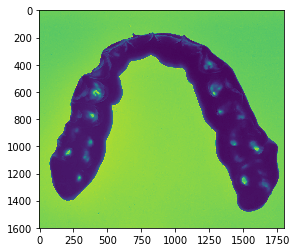

In [34]:
imagen = Image.open('bite.jpg')
im_w, im_h = imagen.size
plt.imshow(imagen)
# plt.imshow(bite)
im_h

In [35]:
import plotly.graph_objs as go
# Create figure
fig = go.Figure()

# Constants
img_width = im_w
img_height = im_h
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
fig.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
fig.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

fig.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
fig.add_layout_image(
    go.layout.Image(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source="bite.jpg")
)

# Configure other layout
fig.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

layout = dict(title=dict(text = 'asagsggsa'), dragmode='lasso')
fig2 = go.FigureWidget(data=fig, layout= layout)


def otra(trace, points, selector):
    global seleccion
    seleccion = selector

fig2.data[0].on_selection(otra)

display(widgets.HBox([fig2]))
# Disable the autosize on double click because it adds unwanted margins around the image
# More detail: https://plot.ly/python/configuration-options/
# fig.show(config={'doubleClick': 'reset'})

    'data': [{'marker': {'opacity': 0},
              'mode': 'markers',
       …

In [57]:
print(seleccion)

LassoSelector(xs=[697.699951171875, 686.699951171875, 681.699951171875,
                  682.699951171875, 687.699951171875, 701.699951171875,
                  720.699951171875, 761.699951171875, 779.699951171875,
                  796.699951171875, 808.699951171875, 824.699951171875,
                  833.699951171875, 842.699951171875, 849.699951171875,
                  848.699951171875, 840.699951171875, 835.699951171875,
                  825.699951171875, 817.699951171875, 809.699951171875,
                  800.699951171875, 781.699951171875, 776.699951171875,
                  772.699951171875, 745.699951171875, 721.699951171875,
                  718.699951171875],
              ys=[364.5833282470703, 334.5833282470703, 314.5833282470703,
                  288.5833282470703, 271.5833282470703, 250.5833282470703,
                  239.5833282470703, 235.5833282470703, 237.5833282470703,
                  243.5833282470703, 252.5833282470703, 259.5833282470703,
               

In [58]:
x = list(map(lambda x: round(x*2), seleccion.xs))
y = list(map(lambda x: round(img_height - x*2), seleccion.ys))
coordenadas_nuevas = list(zip(x, y))
coordenadas_nuevas

[(404, 829),
 (306, 829),
 (274, 797),
 (266, 777),
 (272, 719),
 (286, 683),
 (320, 653),
 (352, 647),
 (406, 661),
 (440, 685),
 (446, 709),
 (444, 785),
 (438, 829),
 (434, 833),
 (436, 833)]

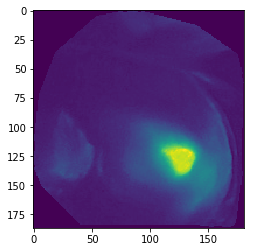

In [59]:
# bite = np.array(image.crop(bite_params))
cut_params = coordenadas_nuevas# [(150,1100),(220,820),(450.40,800),(400,1200.18)]
cut_params = redondear(cut_params)
pts = np.array(cut_params)
## (1) Crop the bounding rect
rect = cv2.boundingRect(pts)
x,y,w,h = rect
croped = bite[y:y+h, x:x+w].copy()

## (2) make mask
pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8)*255
# cv2.bitwise_not(bg,bg, mask=mask)
plt.imshow(dst)
# max(dst[250])
# plt.imshow(255-dst)

In [60]:
class Switch(dict):
    def __getitem__(self, item):
        for key in self.keys():                   # iterate over the intervals
            if item in key:                       # if the argument is part of that interval
                return super().__getitem__(key)   # return its associated value
        raise KeyError(item)                      # if not in any interval, raise KeyError

switch = Switch({
    range(k_pix, 255): 2,
    range(w_pix, k_pix): 1,
    range(0, w_pix): 0
})
print(k_pix)
print(w_pix)

187
87


In [ ]:
# import plotly as pt
# pt.__version__

In [ ]:
# import plotly.express as px
# from skimage import io
# img = io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Crab_Nebula.jpg/240px-Crab_Nebula.jpg')
# fig = px.imshow(img)
# fig.show()

In [61]:
@vectorize([float64(float64)])
def f(x):
    return switch[x]

In [62]:
classification = f(dst)

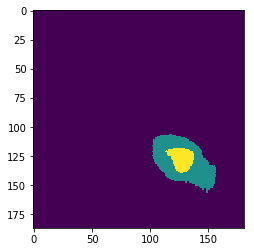

In [63]:
plt.imshow(classification)

In [64]:
import plotly.graph_objs as go
# Create figure
fig = go.Figure()

# Constants
img_width = im_w
img_height = im_h
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
fig.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
fig.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

fig.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
fig.add_layout_image(
    go.layout.Image(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source="bite.jpg")
)

# Configure other layout
fig.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

layout = dict(title=dict(text = 'asagsggsa'), dragmode='lasso')
fig2 = go.FigureWidget(data=fig, layout= layout)


def otra(trace, points, selector):
    global seleccion
    seleccion = selector

fig2.data[0].on_selection(otra)

display(widgets.HBox([fig2]))
# Disable the autosize on double click because it adds unwanted margins around the image
# More detail: https://plot.ly/python/configuration-options/
# fig.show(config={'doubleClick': 'reset'})

    'data': [{'marker': {'opacity': 0},
              'mode': 'markers',
       …